In [6]:
from astropy.io import fits

In [7]:
import numpy as np

In [104]:
# check my download

fits_to_test = '/media/home/team_workspaces/Euclid-Consortium/data/strong_lensing/external_targets_pipeline/latest/cutouts/fits/101544256/EUC_4283_DESI-sel.fits'

hdu = fits.open(fits_to_test)

hdu

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f5314e954c0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f531c344bb0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f531c168a30>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f531506b5e0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f531c0e6e80>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f531c1acb50>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f5314d9a820>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f5314f6e1c0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f5314d91520>]

In [105]:
hdu[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  200                                                  
NAXIS2  =                  200                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                647.0 / Pixel coordinate of reference point            
CRPIX2  =               -275.0 / Pixel coordinate of reference point            
PC1_1   =  -2.777777777778E-05 / Coordinate transformation matrix element       
PC2_2   =   2.777777777778E-05 / Coordinate transformation matrix element       
CDELT1  =                  1

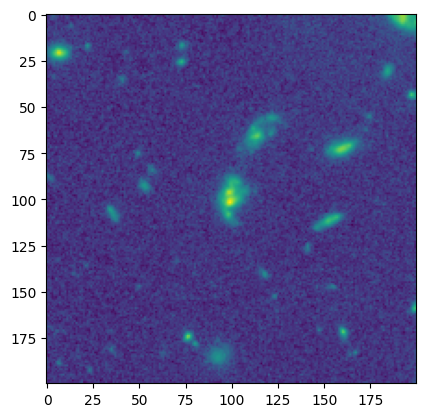

In [106]:
plt.imshow(np.arcsinh(500*hdu[1].data))  # vis image

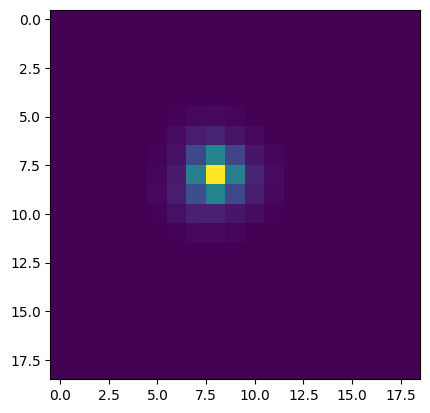

In [107]:
plt.imshow(hdu[2].data)  # vis psf

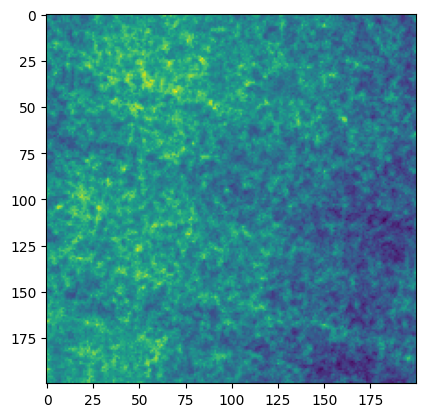

In [108]:
plt.imshow(np.arcsinh(500*hdu[3].data))  # vis rms

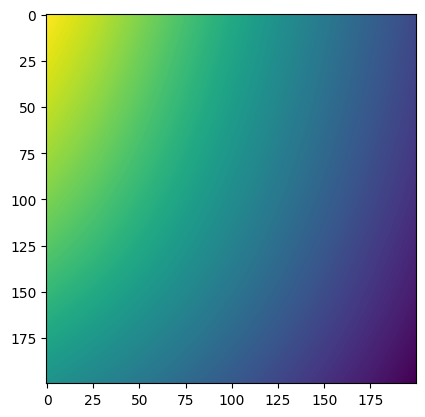

In [109]:
plt.imshow(hdu[4].data)  # vis bkg

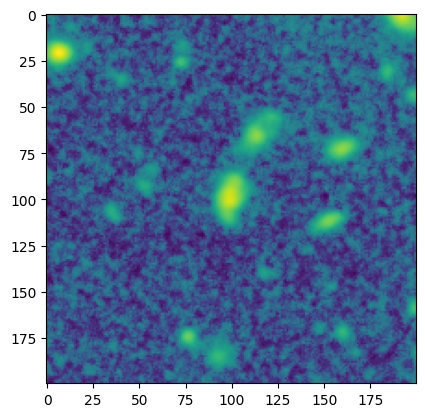

In [110]:
plt.imshow(np.arcsinh(10*hdu[5].data))  # nir y flux

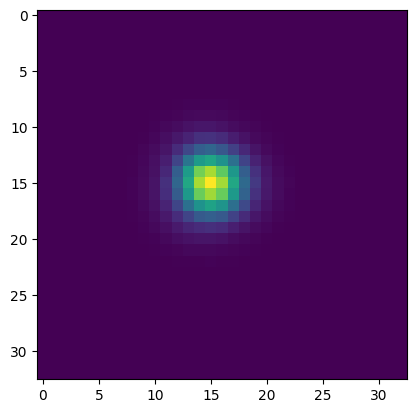

In [111]:
plt.imshow(hdu[6].data)  # nir y psf

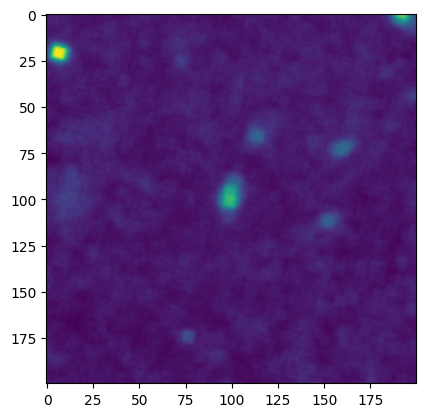

In [112]:
plt.imshow(np.arcsinh(500*hdu[7].data))  # nir y rms

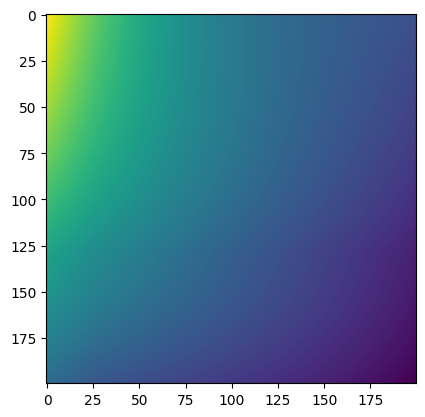

In [113]:
plt.imshow(np.arcsinh(500*hdu[8].data))  # nir y bkg

In [12]:
# let's also check for tile shapes


import glob

fits_dir = '/media/home/team_workspaces/Euclid-Consortium/data/strong_lensing/external_targets_pipeline/demo_lrg/cutouts/fits/*/*.fits'

cutouts = glob.glob(fits_dir)
len(cutouts)


136

In [ ]:

for cutout_loc in cutouts:
    print(fits.getdata(cutout_loc, ext=4).shape)